# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [4]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

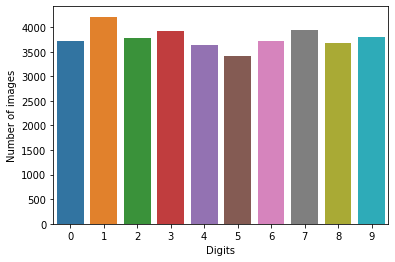

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

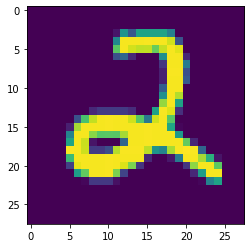

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

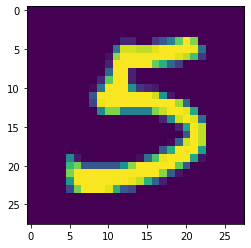

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [14]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [15]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical.
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [16]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [17]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2021-05-20 18:21:25,305] A new study created in RDB with name: cnn_study


Epoch 1/3
266/266 [==============================] - 35s 129ms/step - loss: 0.6645 - accuracy: 0.7852 - val_loss: 0.1099 - val_accuracy: 0.9680
Epoch 2/3
266/266 [==============================] - 44s 165ms/step - loss: 0.0933 - accuracy: 0.9726 - val_loss: 0.1159 - val_accuracy: 0.9706
Epoch 3/3
266/266 [==============================] - 45s 168ms/step - loss: 0.0532 - accuracy: 0.9835 - val_loss: 0.0680 - val_accuracy: 0.9786


[I 2021-05-20 18:23:30,697] Trial 0 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 37, 'optimizer_name': 'Adam', 'learning_rate': 0.001829444754668258}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 19s 64ms/step - loss: 0.5696 - accuracy: 0.8277 - val_loss: 0.1244 - val_accuracy: 0.9619
Epoch 2/3
266/266 [==============================] - 29s 107ms/step - loss: 0.0939 - accuracy: 0.9729 - val_loss: 0.0960 - val_accuracy: 0.9722
Epoch 3/3
266/266 [==============================] - 29s 108ms/step - loss: 0.0593 - accuracy: 0.9817 - val_loss: 0.0702 - val_accuracy: 0.9770


[I 2021-05-20 18:24:47,420] Trial 1 finished with value: 0.9769841432571411 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 218, 'optimizer_name': 'Adam', 'learning_rate': 0.0017379818382761978}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 22s 73ms/step - loss: 0.4895 - accuracy: 0.8444 - val_loss: 0.1351 - val_accuracy: 0.9569
Epoch 2/3
266/266 [==============================] - 19s 72ms/step - loss: 0.1151 - accuracy: 0.9643 - val_loss: 0.1348 - val_accuracy: 0.9622
Epoch 3/3
266/266 [==============================] - 18s 66ms/step - loss: 0.0906 - accuracy: 0.9720 - val_loss: 0.1270 - val_accuracy: 0.9648


[I 2021-05-20 18:25:46,840] Trial 2 finished with value: 0.9648148417472839 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 507, 'optimizer_name': 'Adam', 'learning_rate': 0.003322291633454295}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 52s 184ms/step - loss: 2.2703 - accuracy: 0.6681 - val_loss: 0.2135 - val_accuracy: 0.9421
Epoch 2/3
266/266 [==============================] - 50s 187ms/step - loss: 0.1185 - accuracy: 0.9670 - val_loss: 0.1391 - val_accuracy: 0.9675
Epoch 3/3
266/266 [==============================] - 48s 181ms/step - loss: 0.0806 - accuracy: 0.9784 - val_loss: 0.1239 - val_accuracy: 0.9754


[I 2021-05-20 18:28:18,233] Trial 3 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 316, 'optimizer_name': 'RMSprop', 'learning_rate': 0.009606442320553202, 'momentum': 0.1839557778373304}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 49s 175ms/step - loss: 2.4964 - accuracy: 0.5550 - val_loss: 0.3006 - val_accuracy: 0.9278
Epoch 2/3
266/266 [==============================] - 46s 173ms/step - loss: 0.2159 - accuracy: 0.9451 - val_loss: 0.3561 - val_accuracy: 0.9254
Epoch 3/3
266/266 [==============================] - 42s 159ms/step - loss: 0.1631 - accuracy: 0.9585 - val_loss: 0.2338 - val_accuracy: 0.9550


[I 2021-05-20 18:30:36,895] Trial 4 finished with value: 0.9550264477729797 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 444, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00758290948203356, 'momentum': 0.27763790326823856}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 548s 2s/step - loss: 3.5072 - accuracy: 0.1042 - val_loss: 2.4808 - val_accuracy: 0.1037
Epoch 2/3
266/266 [==============================] - 554s 2s/step - loss: 2.8719 - accuracy: 0.0990 - val_loss: 3.0300 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 627s 2s/step - loss: 2.8988 - accuracy: 0.0950 - val_loss: 2.7967 - val_accuracy: 0.1037


[I 2021-05-20 18:59:26,760] Trial 5 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 455, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004628385823120076, 'momentum': 0.3976856817981471}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 33s 106ms/step - loss: 0.7561 - accuracy: 0.7479 - val_loss: 0.2741 - val_accuracy: 0.9206
Epoch 2/3
266/266 [==============================] - 25s 94ms/step - loss: 0.2273 - accuracy: 0.9368 - val_loss: 0.2374 - val_accuracy: 0.9368
Epoch 3/3
266/266 [==============================] - 13s 51ms/step - loss: 0.2195 - accuracy: 0.9406 - val_loss: 0.3410 - val_accuracy: 0.9251


[I 2021-05-20 19:00:39,744] Trial 6 finished with value: 0.9251322746276855 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 134, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004260383943637079, 'momentum': 0.8557808913273667}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 50s 179ms/step - loss: 3.0398 - accuracy: 0.1042 - val_loss: 2.3760 - val_accuracy: 0.1079
Epoch 2/3
266/266 [==============================] - 46s 171ms/step - loss: 2.5909 - accuracy: 0.1003 - val_loss: 2.5552 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 47s 176ms/step - loss: 2.5468 - accuracy: 0.1007 - val_loss: 2.8352 - val_accuracy: 0.0868


[I 2021-05-20 19:03:03,602] Trial 7 finished with value: 0.08677248656749725 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 233, 'optimizer_name': 'RMSprop', 'learning_rate': 0.004457489102122301, 'momentum': 0.8159990102844568}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 22s 69ms/step - loss: 1.5697 - accuracy: 0.4789 - val_loss: 0.4168 - val_accuracy: 0.8696
Epoch 2/3
266/266 [==============================] - 18s 69ms/step - loss: 0.3511 - accuracy: 0.8983 - val_loss: 0.2768 - val_accuracy: 0.9167
Epoch 3/3
266/266 [==============================] - 18s 68ms/step - loss: 0.2338 - accuracy: 0.9313 - val_loss: 0.2106 - val_accuracy: 0.9378


[I 2021-05-20 19:04:03,524] Trial 8 finished with value: 0.9378306865692139 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 38, 'optimizer_name': 'Adam', 'learning_rate': 0.0004698200874850909}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 15s 44ms/step - loss: 0.5480 - accuracy: 0.8222 - val_loss: 0.1262 - val_accuracy: 0.9638
Epoch 2/3
266/266 [==============================] - 11s 43ms/step - loss: 0.0970 - accuracy: 0.9695 - val_loss: 0.0979 - val_accuracy: 0.9712
Epoch 3/3
266/266 [==============================] - 10s 38ms/step - loss: 0.0662 - accuracy: 0.9788 - val_loss: 0.0957 - val_accuracy: 0.9714


[I 2021-05-20 19:04:41,119] Trial 9 finished with value: 0.9714285731315613 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 433, 'optimizer_name': 'Adam', 'learning_rate': 0.006777103896145297}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 63s 222ms/step - loss: 1.7073 - accuracy: 0.4609 - val_loss: 0.4395 - val_accuracy: 0.8733
Epoch 2/3
266/266 [==============================] - 56s 209ms/step - loss: 0.3916 - accuracy: 0.8887 - val_loss: 0.2872 - val_accuracy: 0.9156
Epoch 3/3
266/266 [==============================] - 57s 216ms/step - loss: 0.2506 - accuracy: 0.9276 - val_loss: 0.2406 - val_accuracy: 0.9280


[I 2021-05-20 19:07:37,859] Trial 10 finished with value: 0.9280423521995544 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 29, 'optimizer_name': 'Adam', 'learning_rate': 0.0001223166490497982}. Best is trial 0 with value: 0.9785714149475098.


Epoch 1/3
266/266 [==============================] - 30s 103ms/step - loss: 0.6331 - accuracy: 0.8031 - val_loss: 0.1121 - val_accuracy: 0.9672
Epoch 2/3
266/266 [==============================] - 16s 61ms/step - loss: 0.0864 - accuracy: 0.9739 - val_loss: 0.0882 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 17s 66ms/step - loss: 0.0511 - accuracy: 0.9836 - val_loss: 0.0644 - val_accuracy: 0.9794


[I 2021-05-20 19:08:42,924] Trial 11 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 163, 'optimizer_name': 'Adam', 'learning_rate': 0.0012097048863652128}. Best is trial 11 with value: 0.9793650507926941.


Epoch 1/3
266/266 [==============================] - 50s 177ms/step - loss: 0.5903 - accuracy: 0.8007 - val_loss: 0.1001 - val_accuracy: 0.9709
Epoch 2/3
266/266 [==============================] - 48s 181ms/step - loss: 0.0782 - accuracy: 0.9763 - val_loss: 0.0884 - val_accuracy: 0.9762
Epoch 3/3
266/266 [==============================] - 53s 199ms/step - loss: 0.0459 - accuracy: 0.9855 - val_loss: 0.0575 - val_accuracy: 0.9839


[I 2021-05-20 19:11:14,630] Trial 12 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 114, 'optimizer_name': 'Adam', 'learning_rate': 0.0020539678624769604}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 31s 107ms/step - loss: 0.5337 - accuracy: 0.8276 - val_loss: 0.0857 - val_accuracy: 0.9767
Epoch 2/3
266/266 [==============================] - 28s 105ms/step - loss: 0.0688 - accuracy: 0.9784 - val_loss: 0.0782 - val_accuracy: 0.9741
Epoch 3/3
266/266 [==============================] - 25s 95ms/step - loss: 0.0415 - accuracy: 0.9860 - val_loss: 0.0597 - val_accuracy: 0.9825


[I 2021-05-20 19:12:39,961] Trial 13 finished with value: 0.9825396537780762 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 134, 'optimizer_name': 'Adam', 'learning_rate': 0.002238674984486938}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 55s 197ms/step - loss: 0.5555 - accuracy: 0.8171 - val_loss: 0.0868 - val_accuracy: 0.9735
Epoch 2/3
266/266 [==============================] - 49s 186ms/step - loss: 0.0698 - accuracy: 0.9785 - val_loss: 0.0962 - val_accuracy: 0.9714
Epoch 3/3
266/266 [==============================] - 50s 187ms/step - loss: 0.0457 - accuracy: 0.9856 - val_loss: 0.0672 - val_accuracy: 0.9783


[I 2021-05-20 19:15:15,695] Trial 14 finished with value: 0.9783068895339966 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 110, 'optimizer_name': 'Adam', 'learning_rate': 0.0027001952210941194}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 68s 242ms/step - loss: 0.9049 - accuracy: 0.6722 - val_loss: 0.1077 - val_accuracy: 0.9701
Epoch 2/3
266/266 [==============================] - 48s 179ms/step - loss: 0.1008 - accuracy: 0.9712 - val_loss: 0.1244 - val_accuracy: 0.9685
Epoch 3/3
266/266 [==============================] - 47s 175ms/step - loss: 0.0678 - accuracy: 0.9811 - val_loss: 0.0890 - val_accuracy: 0.9762


[I 2021-05-20 19:17:59,170] Trial 15 finished with value: 0.976190447807312 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 299, 'optimizer_name': 'Adam', 'learning_rate': 0.006126833548088438}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 8s 26ms/step - loss: 0.6204 - accuracy: 0.8021 - val_loss: 0.1046 - val_accuracy: 0.9693
Epoch 2/3
266/266 [==============================] - 7s 27ms/step - loss: 0.0826 - accuracy: 0.9747 - val_loss: 0.0772 - val_accuracy: 0.9767
Epoch 3/3
266/266 [==============================] - 7s 26ms/step - loss: 0.0550 - accuracy: 0.9821 - val_loss: 0.0698 - val_accuracy: 0.9794


[I 2021-05-20 19:18:22,479] Trial 16 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 97, 'optimizer_name': 'Adam', 'learning_rate': 0.0028115563036979524}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 387s 1s/step - loss: 0.7640 - accuracy: 0.7972 - val_loss: 0.1404 - val_accuracy: 0.9577
Epoch 2/3
266/266 [==============================] - 362s 1s/step - loss: 0.1015 - accuracy: 0.9692 - val_loss: 0.0815 - val_accuracy: 0.9757
Epoch 3/3
266/266 [==============================] - 339s 1s/step - loss: 0.0567 - accuracy: 0.9823 - val_loss: 0.0708 - val_accuracy: 0.9786


[I 2021-05-20 19:36:31,343] Trial 17 finished with value: 0.9785714149475098 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 2, 'units': 180, 'optimizer_name': 'Adam', 'learning_rate': 0.00021741034535812374}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 18s 61ms/step - loss: 0.4700 - accuracy: 0.8503 - val_loss: 0.1072 - val_accuracy: 0.9688
Epoch 2/3
266/266 [==============================] - 15s 55ms/step - loss: 0.0695 - accuracy: 0.9779 - val_loss: 0.0702 - val_accuracy: 0.9812
Epoch 3/3
266/266 [==============================] - 15s 58ms/step - loss: 0.0421 - accuracy: 0.9869 - val_loss: 0.0655 - val_accuracy: 0.9802


[I 2021-05-20 19:37:20,337] Trial 18 finished with value: 0.9801587462425232 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 87, 'optimizer_name': 'Adam', 'learning_rate': 0.0034869187334927985}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 49s 173ms/step - loss: 0.7131 - accuracy: 0.7676 - val_loss: 0.1137 - val_accuracy: 0.9667
Epoch 2/3
266/266 [==============================] - 46s 172ms/step - loss: 0.0975 - accuracy: 0.9689 - val_loss: 0.0986 - val_accuracy: 0.9704
Epoch 3/3
266/266 [==============================] - 47s 175ms/step - loss: 0.0603 - accuracy: 0.9803 - val_loss: 0.0896 - val_accuracy: 0.9741


[I 2021-05-20 19:39:41,949] Trial 19 finished with value: 0.9740740656852722 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 302, 'optimizer_name': 'Adam', 'learning_rate': 0.0008090843685833568}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 17s 53ms/step - loss: 0.6820 - accuracy: 0.7710 - val_loss: 0.1101 - val_accuracy: 0.9683
Epoch 2/3
266/266 [==============================] - 11s 41ms/step - loss: 0.1059 - accuracy: 0.9687 - val_loss: 0.0981 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 12s 45ms/step - loss: 0.0679 - accuracy: 0.9781 - val_loss: 0.0798 - val_accuracy: 0.9757


[I 2021-05-20 19:40:22,787] Trial 20 finished with value: 0.9756613969802856 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 181, 'optimizer_name': 'Adam', 'learning_rate': 0.0024584862687256287}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 19s 63ms/step - loss: 0.4742 - accuracy: 0.8466 - val_loss: 0.0876 - val_accuracy: 0.9770
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0643 - accuracy: 0.9803 - val_loss: 0.0681 - val_accuracy: 0.9807
Epoch 3/3
266/266 [==============================] - 13s 50ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0601 - val_accuracy: 0.9815


[I 2021-05-20 19:41:11,662] Trial 21 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 81, 'optimizer_name': 'Adam', 'learning_rate': 0.0035657052207980705}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 18s 57ms/step - loss: 0.4434 - accuracy: 0.8547 - val_loss: 0.0863 - val_accuracy: 0.9751
Epoch 2/3
266/266 [==============================] - 15s 57ms/step - loss: 0.0596 - accuracy: 0.9821 - val_loss: 0.0629 - val_accuracy: 0.9831
Epoch 3/3
266/266 [==============================] - 15s 55ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 0.0711 - val_accuracy: 0.9788


[I 2021-05-20 19:41:59,653] Trial 22 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 69, 'optimizer_name': 'Adam', 'learning_rate': 0.005759147207410167}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 20s 72ms/step - loss: 0.4673 - accuracy: 0.8462 - val_loss: 0.0970 - val_accuracy: 0.9720
Epoch 2/3
266/266 [==============================] - 18s 67ms/step - loss: 0.0619 - accuracy: 0.9807 - val_loss: 0.0660 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 18s 69ms/step - loss: 0.0362 - accuracy: 0.9882 - val_loss: 0.0573 - val_accuracy: 0.9815


[I 2021-05-20 19:42:56,303] Trial 23 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 140, 'optimizer_name': 'Adam', 'learning_rate': 0.003742762748466514}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 22s 76ms/step - loss: 0.5584 - accuracy: 0.8266 - val_loss: 0.1099 - val_accuracy: 0.9680
Epoch 2/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0761 - accuracy: 0.9767 - val_loss: 0.0937 - val_accuracy: 0.9704
Epoch 3/3
266/266 [==============================] - 17s 65ms/step - loss: 0.0478 - accuracy: 0.9838 - val_loss: 0.0617 - val_accuracy: 0.9839


[I 2021-05-20 19:43:51,821] Trial 24 finished with value: 0.9838624596595764 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 143, 'optimizer_name': 'Adam', 'learning_rate': 0.0018438357670895755}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 24s 81ms/step - loss: 0.5421 - accuracy: 0.8293 - val_loss: 0.1016 - val_accuracy: 0.9698
Epoch 2/3
266/266 [==============================] - 18s 68ms/step - loss: 0.0742 - accuracy: 0.9773 - val_loss: 0.0839 - val_accuracy: 0.9738
Epoch 3/3
266/266 [==============================] - 19s 73ms/step - loss: 0.0437 - accuracy: 0.9863 - val_loss: 0.0631 - val_accuracy: 0.9820


[I 2021-05-20 19:44:53,846] Trial 25 finished with value: 0.9820106029510498 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 209, 'optimizer_name': 'Adam', 'learning_rate': 0.0015802360236340512}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 25s 87ms/step - loss: 0.4839 - accuracy: 0.8443 - val_loss: 0.0889 - val_accuracy: 0.9749
Epoch 2/3
266/266 [==============================] - 19s 73ms/step - loss: 0.0634 - accuracy: 0.9799 - val_loss: 0.0758 - val_accuracy: 0.9780
Epoch 3/3
266/266 [==============================] - 22s 82ms/step - loss: 0.0354 - accuracy: 0.9883 - val_loss: 0.0569 - val_accuracy: 0.9833


[I 2021-05-20 19:46:00,715] Trial 26 finished with value: 0.9833333492279053 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 247, 'optimizer_name': 'Adam', 'learning_rate': 0.001948405166845097}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 361s 1s/step - loss: 0.4235 - accuracy: 0.8654 - val_loss: 0.1070 - val_accuracy: 0.9677
Epoch 2/3
266/266 [==============================] - 361s 1s/step - loss: 0.0665 - accuracy: 0.9797 - val_loss: 0.0823 - val_accuracy: 0.9770
Epoch 3/3
266/266 [==============================] - 302s 1s/step - loss: 0.0344 - accuracy: 0.9893 - val_loss: 0.0808 - val_accuracy: 0.9775


[I 2021-05-20 20:03:06,337] Trial 27 finished with value: 0.9775132536888123 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 363, 'optimizer_name': 'Adam', 'learning_rate': 0.000995359918308186}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 12s 43ms/step - loss: 0.4647 - accuracy: 0.8427 - val_loss: 0.1141 - val_accuracy: 0.9677
Epoch 2/3
266/266 [==============================] - 10s 38ms/step - loss: 0.0672 - accuracy: 0.9801 - val_loss: 0.1051 - val_accuracy: 0.9725
Epoch 3/3
266/266 [==============================] - 11s 42ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0698 - val_accuracy: 0.9794


[I 2021-05-20 20:03:40,031] Trial 28 finished with value: 0.9793650507926941 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 261, 'optimizer_name': 'Adam', 'learning_rate': 0.0053649847727488004}. Best is trial 12 with value: 0.9838624596595764.


Epoch 1/3
266/266 [==============================] - 32s 117ms/step - loss: 1.7501 - accuracy: 0.3009 - val_loss: 1.1696 - val_accuracy: 0.5071
Epoch 2/3
266/266 [==============================] - 30s 113ms/step - loss: 1.0785 - accuracy: 0.5502 - val_loss: 0.4733 - val_accuracy: 0.8606
Epoch 3/3
266/266 [==============================] - 30s 115ms/step - loss: 0.3229 - accuracy: 0.8997 - val_loss: 0.1988 - val_accuracy: 0.9614


[I 2021-05-20 20:05:12,528] Trial 29 finished with value: 0.9613756537437439 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 6, 'optimizer_name': 'Adam', 'learning_rate': 0.0019550329335437837}. Best is trial 12 with value: 0.9838624596595764.


# Analyze results

In [18]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 5,
 'learning_rate': 0.0020539678624769604,
 'num_conv_layers': 3,
 'num_dense_layers': 2,
 'optimizer_name': 'Adam',
 'strides': 2,
 'units': 114}

In [19]:
study.best_value

0.9838624596595764

Text(0, 0.5, 'Accuracy')

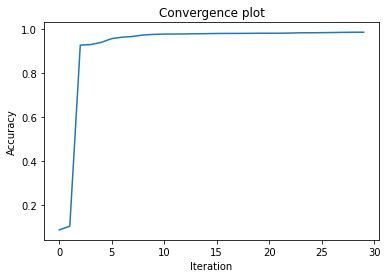

In [20]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Evaluate the model

In [21]:
# load best model

model = load_model(path_best_model)

In [22]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          102464    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 114)               29298     
_________________________________________________________________
dense_36 (Dense)             (None, 114)             

In [23]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 7ms/step - loss: 0.0597 - accuracy: 0.9821


In [24]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05974521115422249
accuracy 0.9821428656578064


## Confusion matrix

In [25]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[416,   0,   0,   0,   1,   0,   2,   0,   3,   0],
       [  0, 466,   3,   0,   0,   0,   1,   2,   1,   0],
       [  2,   0, 405,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 419,   0,   1,   1,   3,   0,   1],
       [  1,   3,   0,   0, 419,   0,   3,   0,   0,   3],
       [  0,   0,   0,   1,   0, 376,   2,   0,   3,   0],
       [  0,   0,   0,   0,   2,   0, 409,   0,   1,   0],
       [  0,   2,   6,   1,   0,   1,   0, 457,   0,   2],
       [  0,   1,   1,   0,   0,   0,   1,   1, 379,   1],
       [  2,   2,   0,   4,   5,   0,   0,   1,   1, 379]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

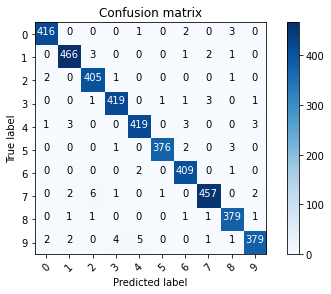

In [26]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.